<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW10-convolutional-neural-network-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading MNIST Dataset
----------------------------------

In [2]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]



## Definition of LeNet-5
Wiki definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)  # With padding=2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling instead of max
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # No padding
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling instead of max

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input size after conv and pooling: 16 feature maps of 5x5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output: 10 classes (digits 0-9)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        # First convolution block
        x = self.conv1(x)        # Convolution
        x = torch.sigmoid(x)     # Sigmoid activation
        x = self.pool1(x)        # Average Pooling

        # Second convolution block
        x = self.conv2(x)        # Convolution
        x = torch.sigmoid(x)     # Sigmoid activation
        x = self.pool2(x)        # Average Pooling

        # Flatten the output for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Training Loop
----------------------

In [4]:
import random
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

losses = []
net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(18):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        losses.append(loss.item())
        if (batch % 30 == 0) or (batch % 30 == 10) or (batch == 20):
            print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3325304985046387
epoch: 0 batch: 10 current batch loss: 2.3101398944854736
epoch: 0 batch: 20 current batch loss: 2.3018200397491455
epoch: 1 batch: 0 current batch loss: 2.301767349243164
epoch: 1 batch: 10 current batch loss: 2.3009986877441406
epoch: 1 batch: 20 current batch loss: 2.2988171577453613
epoch: 2 batch: 0 current batch loss: 2.2868218421936035
epoch: 2 batch: 10 current batch loss: 2.253337860107422
epoch: 2 batch: 20 current batch loss: 2.1852428913116455
epoch: 3 batch: 0 current batch loss: 2.04961895942688
epoch: 3 batch: 10 current batch loss: 1.9106374979019165
epoch: 3 batch: 20 current batch loss: 1.734276294708252
epoch: 4 batch: 0 current batch loss: 1.5211607217788696
epoch: 4 batch: 10 current batch loss: 1.3595638275146484
epoch: 4 batch: 20 current batch loss: 1.1991024017333984
epoch: 5 batch: 0 current batch loss: 1.083864688873291
epoch: 5 batch: 10 current batch loss: 0.980273962020874
epoch: 5 ba

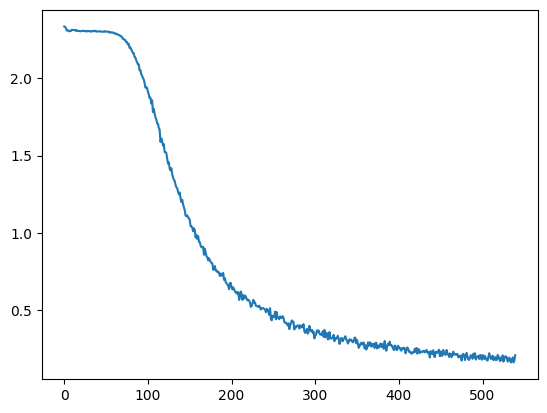

In [5]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# Testing
----------------------

In [6]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9499


# Understanding Kernel Size, Stride and Padding

## Task: Designing a Convolutional Neural Network with a Target Receptive Field

Design a convolutional neural network using only 3×3 or 5×5 convolutional layers and 2×2 max-pooling layers without overlap (i.e., with stride 2). Use no padding in any layer. Insert a max-pooling layer after every two or three convolutional layers.

Your goal is to construct an architecture such that the receptive field of each output neuron is approximately 60×60 pixels.

Compute the receptive field size of the final output layer.

Compute the effective stride of the output layer with respect to the input.

Assuming an input image size of 400×400, determine the spatial size of the output feature map.

Q: Where would you locate ReLU layers?
Q: What if we can't match the desired input size with our architecture?
Q: Discuss what possible impact padding can have on the network performance.



# **Homework Assignment – Adversarial Examples. There will be two tasks**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.




Working on cuda
Optimizing for lambda_l2 = 0 for 30000 epochs
  Epoch 0, Loss: 3.9797
  Epoch 3000, Loss: 0.0113
  Epoch 6000, Loss: 0.0081
  Epoch 9000, Loss: 0.0069
  Epoch 12000, Loss: 0.0064
  Epoch 15000, Loss: 0.0062
  Epoch 18000, Loss: 0.0061
  Epoch 21000, Loss: 0.0060
  Epoch 24000, Loss: 0.0060
  Epoch 27000, Loss: 0.0060
Optimizing for lambda_l2 = 0.01 for 20000 epochs
  Epoch 0, Loss: 4.8834
  Epoch 2000, Loss: 0.0261
  Epoch 4000, Loss: 0.0196
  Epoch 6000, Loss: 0.0162
  Epoch 8000, Loss: 0.0132
  Epoch 10000, Loss: 0.0106
  Epoch 12000, Loss: 0.0087
  Epoch 14000, Loss: 0.0078
  Epoch 16000, Loss: 0.0077
  Epoch 18000, Loss: 0.0077
Optimizing for lambda_l2 = 0.1 for 10000 epochs
  Epoch 0, Loss: 4.8671
  Epoch 1000, Loss: 0.1140
  Epoch 2000, Loss: 0.0902
  Epoch 3000, Loss: 0.0731
  Epoch 4000, Loss: 0.0583
  Epoch 5000, Loss: 0.0452
  Epoch 6000, Loss: 0.0341
  Epoch 7000, Loss: 0.0253
  Epoch 8000, Loss: 0.0189
  Epoch 9000, Loss: 0.0149
Optimizing for lambda_l2 = 1 

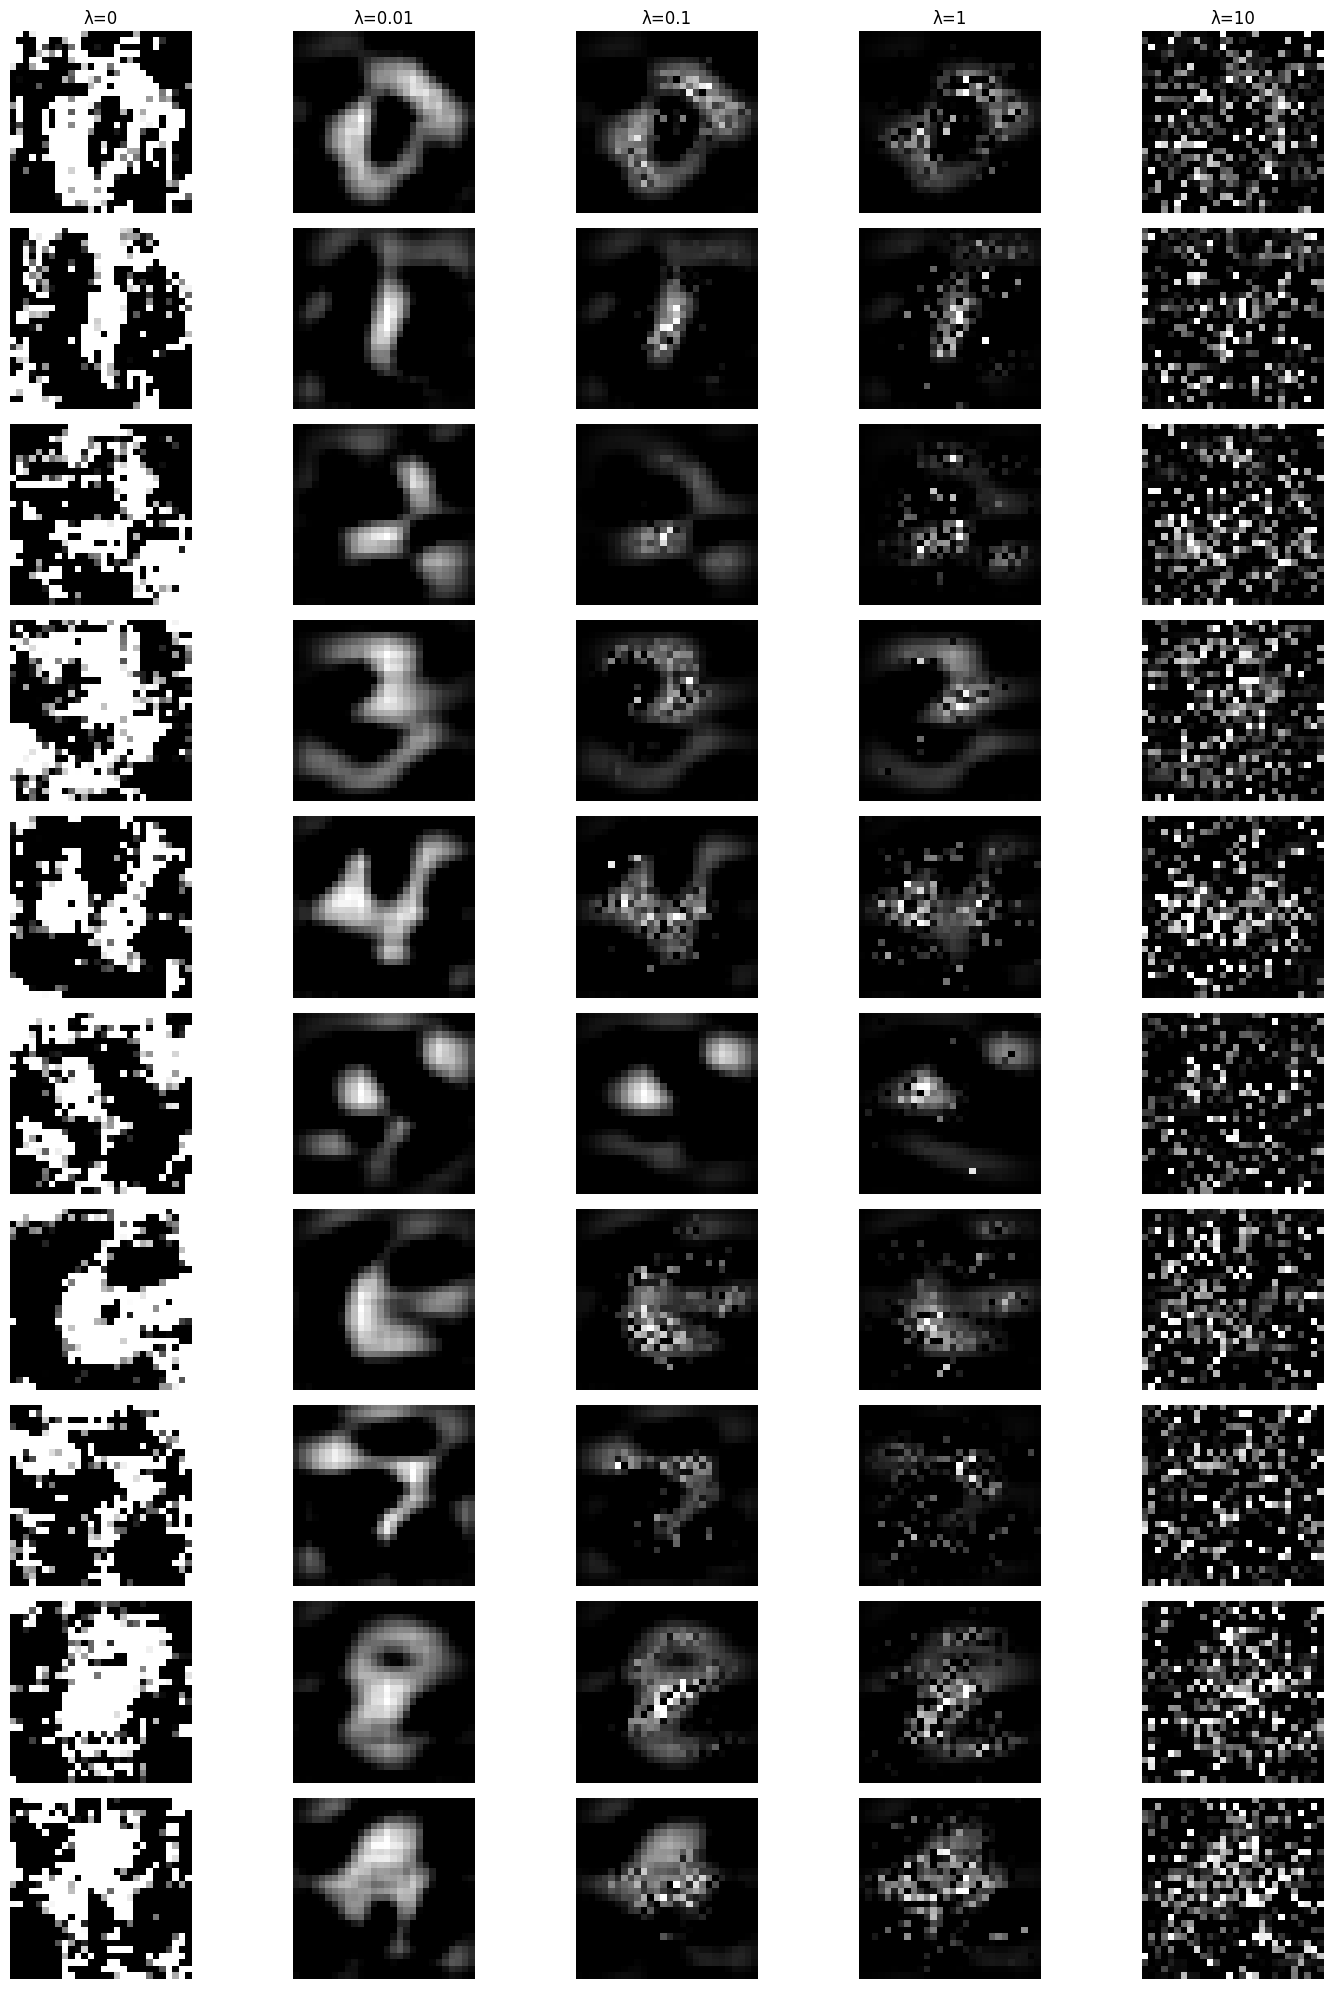

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")
net.eval()

# Hyper-Params
lambda_l2_list = [0, 0.01, 0.1, 1, 10]
epochs_list = [30000, 28000, 10000, 5000, 1000]

final_images_per_lambda = []

for lambda_l2, num_epochs in zip(lambda_l2_list, epochs_list):
    print(f"Optimizing for lambda_l2 = {lambda_l2} for {num_epochs} epochs")

    # Initialize noise (images)
    images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([images], lr=0.001)

    # Epochs
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = net(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets) + lambda_l2 * images.pow(2).mean()
        loss.backward()
        optimizer.step()
        if epoch % max(1, num_epochs // 10) == 0:
            print(f"  Epoch {epoch}, Loss: {loss.item():.4f}")

    # Saving reconstructed images
    final_images = images.detach().clamp(0, 1).cpu()
    final_images_per_lambda.append(final_images)

# Plotting
fig, axs = plt.subplots(10, 5, figsize=(15, 20))  # 10 cyfr, 5 lambd
for col, (lambda_l2, images) in enumerate(zip(lambda_l2_list, final_images_per_lambda)):
    for row in range(10):  # digit from 0 to 9
        axs[row, col].imshow(images[row][0], cmap='gray')
        if row == 0:
            axs[row, col].set_title(f"λ={lambda_l2}")
        axs[row, col].axis('off')
plt.tight_layout()
plt.show()


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.


Working on cuda
Epoch 0, Loss: 4.759758949279785
Epoch 1000, Loss: 0.027645204216241837
Epoch 2000, Loss: 0.015578766353428364
Epoch 3000, Loss: 0.011754227802157402
Epoch 4000, Loss: 0.009829103015363216
Epoch 5000, Loss: 0.008694859221577644
Epoch 6000, Loss: 0.007947360165417194
Epoch 7000, Loss: 0.00741832610219717
Epoch 8000, Loss: 0.007028867490589619
Epoch 9000, Loss: 0.006734816823154688
Epoch 10000, Loss: 0.006508606020361185
Epoch 11000, Loss: 0.006332919001579285
Epoch 12000, Loss: 0.006196391303092241
Epoch 13000, Loss: 0.006090377923101187
Epoch 14000, Loss: 0.006006975658237934
Epoch 15000, Loss: 0.005940772593021393
Epoch 16000, Loss: 0.005889157298952341
Epoch 17000, Loss: 0.005848884582519531
Epoch 18000, Loss: 0.005817492958158255
Epoch 19000, Loss: 0.005793136544525623
Epoch 20000, Loss: 0.005773742683231831
Epoch 21000, Loss: 0.005758269689977169
Epoch 22000, Loss: 0.005745806731283665
Epoch 23000, Loss: 0.005735677666962147
Epoch 24000, Loss: 0.005727432668209076
E

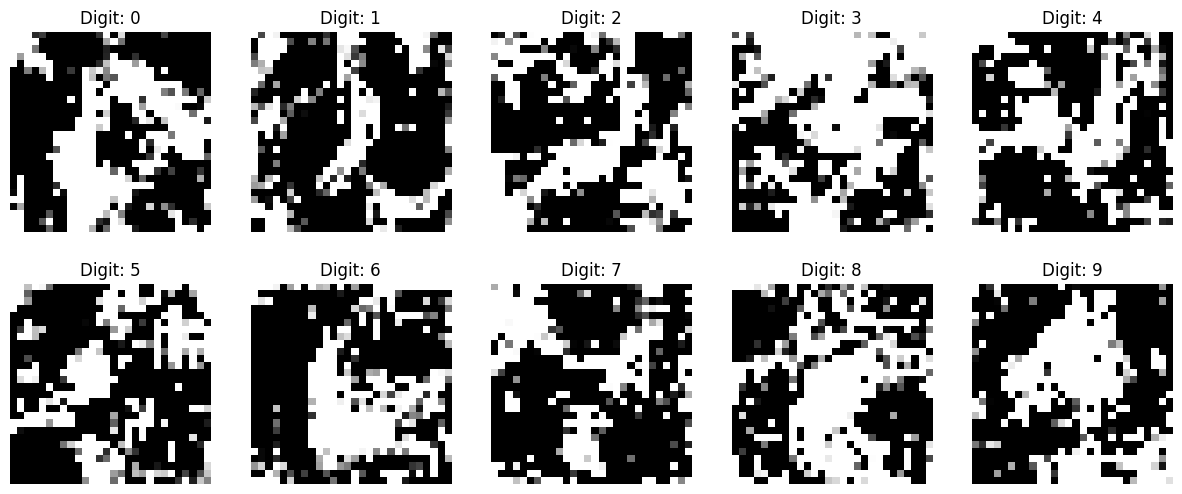

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

images = torch.randn((10, 1 , 28, 28), device=device, requires_grad=True)
targets = torch.arange(10, device=device)
optimizer = torch.optim.Adam([images], lr=0.001)

lambda_l2 = 0.0 # Check lambdas > 0.0
# Now we perform input image optimisation with additional L2 penalty
net.eval()

for epoch in range(40000):
    optimizer.zero_grad()
    outputs = net(images)
    loss = torch.nn.functional.cross_entropy(outputs, targets) + lambda_l2 * images.pow(2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# And finally displaying the images.
final_images = images.detach().clamp(0,1).cpu()
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(final_images[i][0], cmap='gray')
    axs[row, col].set_title(f"Digit: {i}")
    axs[row, col].axis('off')
plt.show()